# Testing with new data

<img src="../images/06.jpg" width="600"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from tools import dataoveriew, plot_roc_curve, plot_confusion_matrix
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

pd.options.display.max_columns = None

class_names = ['Activo','Baja']

%matplotlib inline

In [2]:
data = pd.read_excel('../data/test_feb21.xlsx')
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2021-02-01,550000,Domusa,Murcia,Hombre,España,1958-10-06,Propiedad Total,Jubilado,Casado,1200,12,2021-02-01,ACTIVO,Piso,Financiado,Mas de 500 EUR,1099,NaN,0,237.06
1,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,ACTIVO,Tienda,Financiado,0 - 100 EUR,499,NaN,0,272.03
2,2021-02-01,550002,Domusa,Murcia,Hombre,España,1947-02-02,Propiedad Total,Jubilado,Casado,1500,14,2021-02-01,ACTIVO,Chalet,Financiado,200 - 300 EUR,599,NaN,0,203.33
3,2021-02-01,550003,Domusa,Barcelona,Hombre,Africa,1963-02-02,Alquiler,Trabajo Fijo,Casado,1500,14,2021-02-01,ACTIVO,Piso,Financiado,100 - 200 EUR,499,NaN,0,22.12
4,2021-02-01,550004,Domusa,Madrid,Hombre,España,1965-02-11,Propiedad Total,Autonomo,Casado,1200,12,2021-04-07,BAJA,Piso,Financiado,Promo 0 EUR,399,1.0,3,34.91


In [3]:
data.shape

(10243, 21)

In [4]:
data.isnull().sum()

Fecha Alta              0
Cliente                 0
Modelo Caldera          0
Provincia               0
Gender                  0
Pais                    0
Born Date              74
Tipo Propiedad          0
Situacion Laboral       0
Estado Civil            0
Ingresos                0
Pagos Anuales           0
Fecha Estado            0
Estado                  0
Tipo Inmueble           0
Financiado              0
Precio Contado          0
Precio Total            0
Quejas               9909
Incidencias             0
Consumo Mes             0
dtype: int64

In [5]:
data['Quejas'] = data['Quejas'].replace(np.nan, 0).astype('int')
data['Cliente'] = data['Cliente'].astype('str')
data['Estado'] = data['Estado'].astype('str').str.strip()
data['Estado'] = data['Estado'].replace({'ACTIVO': 0, 'BAJA': 1}).astype(int)
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2021-02-01,550000,Domusa,Murcia,Hombre,España,1958-10-06,Propiedad Total,Jubilado,Casado,1200,12,2021-02-01,0,Piso,Financiado,Mas de 500 EUR,1099,0,0,237.06
1,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03
2,2021-02-01,550002,Domusa,Murcia,Hombre,España,1947-02-02,Propiedad Total,Jubilado,Casado,1500,14,2021-02-01,0,Chalet,Financiado,200 - 300 EUR,599,0,0,203.33
3,2021-02-01,550003,Domusa,Barcelona,Hombre,Africa,1963-02-02,Alquiler,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,22.12
4,2021-02-01,550004,Domusa,Madrid,Hombre,España,1965-02-11,Propiedad Total,Autonomo,Casado,1200,12,2021-04-07,1,Piso,Financiado,Promo 0 EUR,399,1,3,34.91


### Feature engineering

In [6]:
data['Born Date'].isnull().sum()

74

In [7]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

In [8]:
data['Born Date'].isnull().sum()

0

In [9]:
# Edad en el momento del alta

data['Edad'] = ((data['Fecha Alta'] - data['Born Date']).dt.days)/365
                        
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad
0,2021-02-01,550000,Domusa,Murcia,Hombre,España,1958-10-06,Propiedad Total,Jubilado,Casado,1200,12,2021-02-01,0,Piso,Financiado,Mas de 500 EUR,1099,0,0,237.06,62.367123
1,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03,47.041096
2,2021-02-01,550002,Domusa,Murcia,Hombre,España,1947-02-02,Propiedad Total,Jubilado,Casado,1500,14,2021-02-01,0,Chalet,Financiado,200 - 300 EUR,599,0,0,203.33,74.049315
3,2021-02-01,550003,Domusa,Barcelona,Hombre,Africa,1963-02-02,Alquiler,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,22.12,58.038356
4,2021-02-01,550004,Domusa,Madrid,Hombre,España,1965-02-11,Propiedad Total,Autonomo,Casado,1200,12,2021-04-07,1,Piso,Financiado,Promo 0 EUR,399,1,3,34.91,56.010959


In [10]:
edad_mean = data['Edad'].mean()
data['Edad'] = data['Edad'].apply(lambda x: edad_mean if x<18 else x)

In [11]:
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad
0,2021-02-01,550000,Domusa,Murcia,Hombre,España,1958-10-06,Propiedad Total,Jubilado,Casado,1200,12,2021-02-01,0,Piso,Financiado,Mas de 500 EUR,1099,0,0,237.06,62.367123,60-70
1,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03,47.041096,40-50
2,2021-02-01,550002,Domusa,Murcia,Hombre,España,1947-02-02,Propiedad Total,Jubilado,Casado,1500,14,2021-02-01,0,Chalet,Financiado,200 - 300 EUR,599,0,0,203.33,74.049315,70-80
3,2021-02-01,550003,Domusa,Barcelona,Hombre,Africa,1963-02-02,Alquiler,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,22.12,58.038356,50-60
4,2021-02-01,550004,Domusa,Madrid,Hombre,España,1965-02-11,Propiedad Total,Autonomo,Casado,1200,12,2021-04-07,1,Piso,Financiado,Promo 0 EUR,399,1,3,34.91,56.010959,50-60


In [12]:
data.loc[data['Ingresos'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Ingresos'] > 1000) & (data['Ingresos'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Ingresos'] > 1500) & (data['Ingresos'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Ingresos'] > 2000) & (data['Ingresos'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Ingresos'] > 3000, 'Income'] = "+3000"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income
0,2021-02-01,550000,Domusa,Murcia,Hombre,España,1958-10-06,Propiedad Total,Jubilado,Casado,1200,12,2021-02-01,0,Piso,Financiado,Mas de 500 EUR,1099,0,0,237.06,62.367123,60-70,1000-1500
1,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03,47.041096,40-50,1000-1500
2,2021-02-01,550002,Domusa,Murcia,Hombre,España,1947-02-02,Propiedad Total,Jubilado,Casado,1500,14,2021-02-01,0,Chalet,Financiado,200 - 300 EUR,599,0,0,203.33,74.049315,70-80,1000-1500
3,2021-02-01,550003,Domusa,Barcelona,Hombre,Africa,1963-02-02,Alquiler,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,22.12,58.038356,50-60,1000-1500
4,2021-02-01,550004,Domusa,Madrid,Hombre,España,1965-02-11,Propiedad Total,Autonomo,Casado,1200,12,2021-04-07,1,Piso,Financiado,Promo 0 EUR,399,1,3,34.91,56.010959,50-60,1000-1500


In [13]:
# Copia para mostrar el resultado antes de realizar el escalado de variables

data_to_result = data.copy()

Transformaciones con `.pkl`

In [14]:
filename = '../pkl/quejas_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Quejas_sca'] = scaler.transform(data['Quejas'].values.reshape(-1, 1))

In [15]:
filename = '../pkl/incidencias_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Incidencias_sca'] = scaler.fit_transform(data['Incidencias'].values.reshape(-1, 1))

In [16]:
filename = '../pkl/consumo_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Consumo_sca'] = scaler.fit_transform(data['Consumo Mes'].values.reshape(-1, 1))

In [17]:
data_filtered = data[['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral', 'Estado Civil', 
                      'Provincia', 'Pais', 'Rango_Edad', 'Income', 'Precio Contado', 'Pagos Anuales', 'Precio Total',
                      'Quejas_sca', 'Incidencias_sca', 'Consumo_sca', 'Estado']]
data_filtered.columns

Index(['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Provincia', 'Pais', 'Rango_Edad', 'Income',
       'Precio Contado', 'Pagos Anuales', 'Precio Total', 'Quejas_sca',
       'Incidencias_sca', 'Consumo_sca', 'Estado'],
      dtype='object')

In [18]:
X = data_filtered.drop(['Estado'],axis=1)
y = data_filtered['Estado']

In [19]:
X.columns

Index(['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Provincia', 'Pais', 'Rango_Edad', 'Income',
       'Precio Contado', 'Pagos Anuales', 'Precio Total', 'Quejas_sca',
       'Incidencias_sca', 'Consumo_sca'],
      dtype='object')

In [20]:
filename = '../pkl/TE_encoder.pkl'
TE_encoder = pickle.load(open(filename, 'rb'))
X = TE_encoder.transform(X)

In [21]:
X.head()

,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Precio Total,Quejas_sca,Incidencias_sca,Consumo_sca
0,0.234403,0.180630,0.207953,0.137000,0.206019,0.235747,0.229953,0.139265,0.243846,0.129438,0.280445,0.146893,0.00000,0.0,0.235582
1,0.234403,0.454948,0.467591,0.325414,0.206019,0.272410,0.229953,0.248319,0.243846,0.285456,0.197137,0.225737,0.00000,0.0,0.270354
2,0.234403,0.187376,0.207953,0.137000,0.206019,0.235747,0.229953,0.127038,0.243846,0.209616,0.197137,0.210503,0.00000,0.0,0.202044
3,0.234403,0.180630,0.467591,0.196445,0.206019,0.179649,0.592040,0.186532,0.243846,0.219361,0.197137,0.225737,0.00000,0.0,0.021865
4,0.234403,0.180630,0.207953,0.325414,0.206019,0.219032,0.229953,0.186532,0.243846,0.268617,0.280445,0.275771,0.02381,0.5,0.034582


### Predicciones con modelos en `.pkl`

Random Forest Classifier:

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     10173
           1       0.04      0.67      0.07        70

    accuracy                           0.88     10243
   macro avg       0.52      0.78      0.50     10243
weighted avg       0.99      0.88      0.93     10243



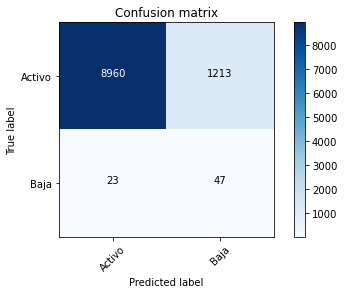

In [22]:
filename = '../pkl/rfc_model.pkl'
rfc = pickle.load(open(filename, 'rb'))

y_pred = rfc.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Regresión Logística:

              precision    recall  f1-score   support

           0       1.00      0.76      0.86     10173
           1       0.02      0.90      0.05        70

    accuracy                           0.76     10243
   macro avg       0.51      0.83      0.45     10243
weighted avg       0.99      0.76      0.85     10243



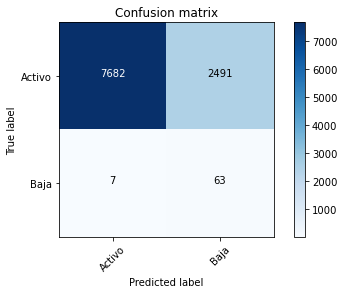

In [23]:
filename = '../pkl/LR_model.pkl'
LR = pickle.load(open(filename, 'rb'))

y_pred = LR.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Decission Tree Classifier:

              precision    recall  f1-score   support

           0       1.00      0.76      0.86     10173
           1       0.03      0.91      0.05        70

    accuracy                           0.76     10243
   macro avg       0.51      0.84      0.46     10243
weighted avg       0.99      0.76      0.86     10243



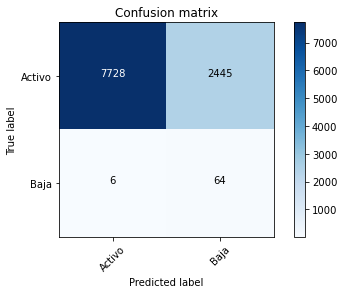

In [24]:
filename = '../pkl/DT_model.pkl'
DT = pickle.load(open(filename, 'rb'))

y_pred = DT.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Voting Classifier:

              precision    recall  f1-score   support

           0       1.00      0.76      0.86     10173
           1       0.03      0.93      0.05        70

    accuracy                           0.76     10243
   macro avg       0.51      0.84      0.46     10243
weighted avg       0.99      0.76      0.86     10243



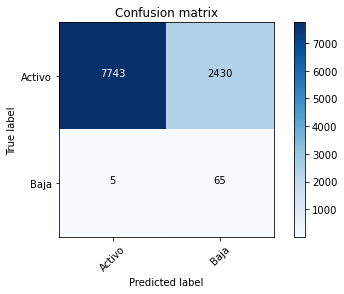

In [25]:
filename = '../pkl/voting_clf_model.pkl'
voting_clf = pickle.load(open(filename, 'rb'))

y_pred = voting_clf.predict(X)
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

#### Exportar resultados

In [26]:
result_rfc = rfc.predict_proba(X)[:,1].reshape(-1, 1)
result_LR = LR.predict_proba(X)[:,1].reshape(-1, 1)
result_DT = DT.predict_proba(X)[:,1].reshape(-1, 1)
result_VC = voting_clf.predict_proba(X)[:,1].reshape(-1, 1)

In [27]:
df_rfc = pd.DataFrame(result_rfc, columns = ['Random Forest'])
df_LR = pd.DataFrame(result_LR, columns = ['Logistic Regression'])
df_DT = pd.DataFrame(result_DT, columns = ['Decission Tree'])
df_VC = pd.DataFrame(result_VC, columns = ['Voting Classifier'])

In [28]:
result = pd.concat([data_to_result, df_rfc, df_LR, df_DT, df_VC], axis = 1)
result.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Random Forest,Logistic Regression,Decission Tree,Voting Classifier
0,2021-02-01,550000,Domusa,Murcia,Hombre,España,1958-10-06,Propiedad Total,Jubilado,Casado,1200,12,2021-02-01,0,Piso,Financiado,Mas de 500 EUR,1099,0,0,237.06,62.367123,60-70,1000-1500,0.115904,0.142457,0.216161,0.179309
1,2021-02-01,550001,Domusa,Valencia,Hombre,España,1974-01-29,Alquiler,Autonomo,Casado,1400,14,2021-02-01,0,Tienda,Financiado,0 - 100 EUR,499,0,0,272.03,47.041096,40-50,1000-1500,0.441017,0.707090,0.555472,0.631281
2,2021-02-01,550002,Domusa,Murcia,Hombre,España,1947-02-02,Propiedad Total,Jubilado,Casado,1500,14,2021-02-01,0,Chalet,Financiado,200 - 300 EUR,599,0,0,203.33,74.049315,70-80,1000-1500,0.135873,0.174072,0.216161,0.195116
3,2021-02-01,550003,Domusa,Barcelona,Hombre,Africa,1963-02-02,Alquiler,Trabajo Fijo,Casado,1500,14,2021-02-01,0,Piso,Financiado,100 - 200 EUR,499,0,0,22.12,58.038356,50-60,1000-1500,0.235840,0.487884,0.082440,0.285162
4,2021-02-01,550004,Domusa,Madrid,Hombre,España,1965-02-11,Propiedad Total,Autonomo,Casado,1200,12,2021-04-07,1,Piso,Financiado,Promo 0 EUR,399,1,3,34.91,56.010959,50-60,1000-1500,0.555030,0.776042,0.902188,0.839115


In [29]:
result.to_excel('../data/result_test.xlsx', index=False)